# Examine CO$_2$ records from Palmer Station (PSA) and South Pole (SPO)

Key question: does the PSA-SPO difference provide a good metric of the fluxes?

In [3]:
%matplotlib inline
from config_calc import *

import warnings

from datetime import datetime
import numpy as np
import xarray as xr
import pandas as pd

import cftime
import esmlab
import grid_tools as gt

import xcalendar as xcal

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['mathtext.default']='regular'

### Read the observational data

In [4]:
def compute_time(df):
    time_bnd = np.empty((len(df), 2))
    left = [cftime.datetime(year, mon, 1) for year, mon in zip(df.year, df.mon)]
    right = [cftime.datetime(year, mon, xcal.dpm['standard'][mon-1]) for year, mon in zip(df.year, df.mon)]
    time_bnd[:, 0] = [cftime.date2num(d, units='days since 0001-01-01')-1. for d in left]
    time_bnd[:, 1] = [cftime.date2num(d, units='days since 0001-01-01') for d in right]
    return cftime.num2date(time_bnd.mean(axis=1), units='days since 0001-01-01')


In [5]:
df = pd.read_csv('data/psa-spo-data/NOAA_PSA_flask_CO2.txt', header=0, sep='\s+')
psa_noaa = xr.DataArray(df.co2, dims=('time',), 
                        coords={'time': compute_time(df)}, name='PSA_CO2_NOAA')

df = pd.read_csv('data/psa-spo-data/NOAA_SPO_insitu_CO2.txt', header=0, sep='\s+')
spo_noaa = xr.DataArray(df.co2, dims=('time',), 
                        coords={'time': compute_time(df)}, name='SPO_CO2_NOAA')

df = pd.read_csv('data/psa-spo-data/SIO_PSA_flask_CO2_onWMOscale.txt', header=0, sep='\s+')
psa_sio = xr.DataArray(df.co2, dims=('time',), 
                        coords={'time': compute_time(df)}, name='PSA_CO2_SIO')


obs = xr.merge(xr.align(*[psa_noaa, spo_noaa], join='inner'))
obs = xr.merge(xr.align(*[obs, psa_sio], join='outer'))
obs['PSA_m_SPO_NOAA'] = obs.PSA_CO2_NOAA - obs.SPO_CO2_NOAA
obs['PSA_CO2_avg'] = (obs.PSA_CO2_NOAA + obs.PSA_CO2_SIO)/2.
obs['PSA_m_SPO'] = obs.PSA_CO2_avg - obs.SPO_CO2_NOAA
obs

<xarray.Dataset>
Dimensions:         (time: 487)
Coordinates:
  * time            (time) datetime64[ns] 1978-01-15T12:00:00 ... 2018-12-15T12:00:00
Data variables:
    PSA_CO2_NOAA    (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    SPO_CO2_NOAA    (time) float64 332.1 331.9 331.9 332.3 ... nan nan nan nan
    PSA_CO2_SIO     (time) float64 nan nan nan nan ... 405.9 405.9 405.9 405.8
    PSA_m_SPO_NOAA  (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    PSA_CO2_avg     (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    PSA_m_SPO       (time) float64 nan nan nan nan nan ... nan nan nan nan nan

Check relative to Britt's calculation

In [6]:


obs_i = []
for year in np.unique(obs['time.year'].values):
    ndxi = np.where(((obs['time.year'] == year) & 
                    ((obs['time.month'] == 1) | (obs['time.month']==2))) | 
                    ((obs['time.year'] == year-1) & (obs['time.month']==12)))[0]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        obs_y = obs.isel(time=ndxi).mean('time')
    obs_y['time'] = datetime(year, 1, 1)    
    obs_i.append(obs_y)
    
obs_djf = xr.concat(obs_i, dim='time')

# year 2001 is an outlier
obs_djf.PSA_m_SPO[obs_djf['time.year']==2001] = np.nan


/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


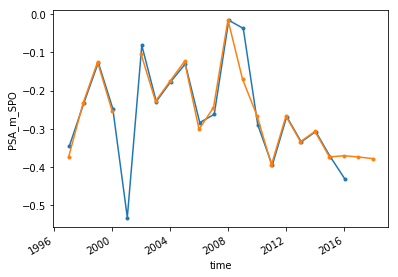

In [7]:
""" data from Britt in email: DJF PSA - SPO
1996.063 NA
1997.042 -0.3452806
1998.042 -0.2329669
1999.042 -0.1268036
2000.041 -0.2470574
2001.042 -0.5321088
2002.042 -0.08169376
2003.042 -0.2286881
2004.041 -0.1767261
2005.042 -0.1303021
2006.042 -0.2838566
2007.042 -0.2620652
2008.041 -0.01607143
2009.042 -0.0373955
2010.042 -0.2894824
2011.042 -0.3958597
2012.041 -0.2680332
2013.042 -0.3343766
2014.042 -0.3073265
2015.042 -0.3728069
2016.054 -0.430666
2016.979 -0.3851458 ### incomplete
"""


time = []
for year in range(1997, 2017):
    eof = 29 if year % 4 == 0 else 28
    dates = cftime.date2num(np.array([cftime.datetime(year-1, 12, 1), cftime.datetime(year, 1, 31), cftime.datetime(year, 2, eof)]), 
                            units='days since 0001-01-01').mean()
    dates = cftime.num2date(dates, units='days since 0001-01-01')
    time.append(datetime(dates.year, dates.month, dates.day))

obs_djf_old = xr.Dataset({
        'time' : xr.DataArray(
            np.array(time),
            dims = ('time')),
        'psa_m_spo' : xr.DataArray(
            np.array([-0.3452806, -0.2329669, -0.1268036, -0.2470574, -0.5321088, -0.08169376, -0.2286881, -0.1767261,
                      -0.1303021, -0.2838566, -0.2620652, -0.01607143, -0.0373955, -0.2894824, -0.3958597, -0.2680332,
                      -0.3343766, -0.3073265, -0.3728069, -0.430666]),
            dims = ('time'))})
obs_djf_old

obs_djf_old.psa_m_spo.plot(marker='.')
obs_djf.PSA_m_SPO.plot(marker='.')


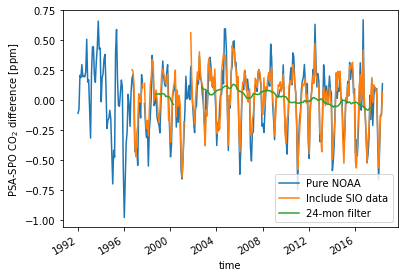

In [18]:
obs.PSA_m_SPO_NOAA.plot(label='Pure NOAA')
obs.PSA_m_SPO.plot(label='Include SIO data')
obs.PSA_m_SPO.rolling(time=24, center=True).mean().plot(label='24-mon filter')
plt.legend()
plt.ylabel('PSA-SPO CO$_2$ difference [ppm]')
plt.savefig(f'{diro["fig"]}/psa-spo-obs-raw-diff.png', bbox_inches='tight', dpi=300)

In [19]:
file_in = '/glade/work/mclong/pco2-landschutzer/downloaded/MPI-SOM_FFN_GCB2018.nc'
ds = xr.open_dataset(file_in, drop_variables='date') # xarray gets hung up on the date var: omit
area = gt.compute_grid_area(ds.lon.values, ds.lat.values)
ds['area'] = xr.DataArray(area, dims=('lat', 'lon'))
ds

total area = 5.1009974330982400e+14
check area = 5.1009969907076156e+14


<xarray.Dataset>
Dimensions:         (bnds: 2, lat: 180, lon: 360, time: 432)
Coordinates:
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time            (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2017-12-15
Dimensions without coordinates: bnds
Data variables:
    spco2           (time, lat, lon) float32 ...
    fgco2           (time, lat, lon) float32 ...
    spco2_smoothed  (time, lat, lon) float32 ...
    fgco2_smoothed  (time, lat, lon) float32 ...
    seamask         (lat, lon) int32 ...
    time_bnds       (time, bnds) datetime64[ns] ...
    lat_bnds        (lat, bnds) float32 ...
    lon_bnds        (lon, bnds) float32 ...
    area            (lat, lon) float32 107893940.0 107892470.0 ... 107893940.0
Attributes:
    institution:    Max Planck Institute for Meteorology, Hamburg, Germany
    institude_id:   MPI-M
    model_id:       SOM-FFN
    run_id:         SOM_FF

In [20]:
dstmp =  xr.open_dataset(file_in, drop_variables='date', decode_times=False)
dstmp['time'] = cftime.num2date(dstmp.time, units=dstmp.time.attrs['units'], only_use_cftime_datetimes=True)
ds_ann = esmlab.resample(dstmp, freq='ann')
ds_ann.time.values = [datetime(d.year, d.month, d.day) for d in ds_ann.time.values]
ds_ann

/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:         (bnds: 2, lat: 180, lon: 360, time: 36)
Coordinates:
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time            (time) datetime64[ns] 1982-06-30 1983-06-30 ... 2017-06-30
Dimensions without coordinates: bnds
Data variables:
    spco2           (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    fgco2           (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    spco2_smoothed  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    fgco2_smoothed  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    time_bnds       (time, bnds) float64 -5.537e+08 -5.511e+08 ... 5.535e+08
    seamask         (lat, lon) int32 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
    lat_bnds        (lat, bnds) float32 -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
    lon_bnds        (lon, bnds) float32 -180.0 -179.0 -179.0 ... 

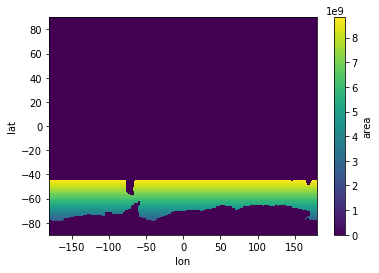

In [60]:
southern_ocean_lat = -44.
wgt = ds.area.where((ds.seamask>0) & (ds.lat < southern_ocean_lat)).fillna(0.)
wgt.plot()

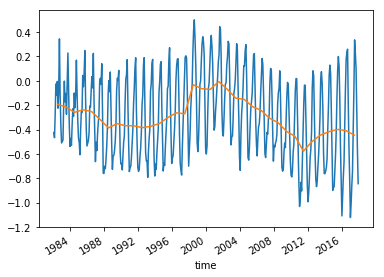

In [61]:
molyr_to_PgCyr = 12e-15
soflux_ann = esmlab.statistics.weighted_sum(ds_ann.fgco2, weights=wgt, dim=('lat', 'lon'))
soflux = esmlab.statistics.weighted_sum(ds.fgco2, weights=wgt, dim=('lat', 'lon'))
soflux = soflux * molyr_to_PgCyr
soflux_ann = soflux_ann * molyr_to_PgCyr
soflux.attrs['long_name'] = 'Air-sea flux'
soflux.attrs['units'] = 'PgC yr$^{-1}$'
soflux.plot()
soflux_ann.plot()

In [62]:
da_list = []
for year in range(1997, 2017):
    ndxi = np.where(((soflux['time.year'] == year) & 
                    ((soflux['time.month']==1) | (soflux['time.month']==2))) | 
                    ((soflux['time.year'] == year-1) & (soflux['time.month']==12)))[0]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        da_y = soflux.isel(time=ndxi).mean('time')
    da_y['time'] = datetime(year, 1, 1)
    da_list.append(da_y)
soflux_djf = xr.concat(da_list, dim='time') 
    

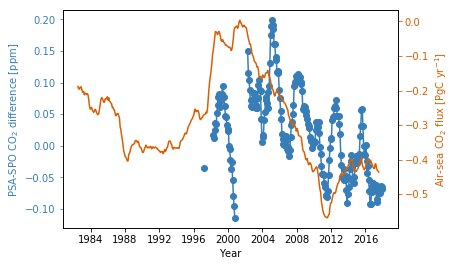

In [67]:
fig = plt.figure()#figsize=[12,12])
ax = fig.add_subplot(111)

ax.plot(obs.time, obs.PSA_m_SPO.rolling(time=12, center=True).mean(),'o-', color='#377eb8')

ax.tick_params('y', colors='#377eb8')
ax.set_ylabel('PSA-SPO CO$_2$ difference [ppm]', color='#377eb8')
ax.set_xlabel('Year')

axR = ax.twinx()
plt.plot(soflux.time, soflux.rolling(time=12, center=True).mean(), color='#d95f02')

axR.tick_params('y', colors='#d95f02')
axR.set_ylabel('Air-sea CO$_2$ flux [PgC yr$^{-1}$]', color='#d95f02')

plt.savefig(f'{diro["fig"]}/psa-spo-diff-obs.png', bbox_inches='tight', dpi=300)

[0.15799125 0.22652328]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     29.41
Date:                Mon, 22 Apr 2019   Prob (F-statistic):           6.05e-07
Time:                        21:38:38   Log-Likelihood:                 62.646
No. Observations:                  82   AIC:                            -121.3
Df Residuals:                      80   BIC:                            -116.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1580      0

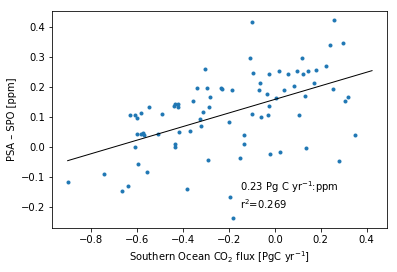

In [68]:
import statsmodels.api as sm
from scipy import stats
x, y = xr.align(soflux, obs.PSA_m_SPO, join='inner')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, '.')

k = ~np.isnan(x) & ~np.isnan(y)
model = sm.OLS(y.values[k], sm.add_constant(x.values[k]))
fitted = model.fit()

print(fitted.params)
print(fitted.summary())

xhat = np.linspace(x.min(),x.max(),50)
yhat = fitted.predict(sm.add_constant(xhat))
ax.plot(xhat, yhat,'-',linewidth=1, color='k',zorder=10) 

ax.text(-0.15, -0.2,'{0:0.2f} Pg C yr$^{{-1}}$:ppm\nr$^2$={1:0.3f}'.format(fitted.params[1],fitted.rsquared))

ax.set_xlabel('Southern Ocean CO$_2$ flux [PgC yr$^{-1}$]')
ax.set_ylabel('PSA – SPO [ppm]')
#ax.set_title(n)

plt.savefig(f'{diro["fig"]}/psa-spo-v-flux-obs.png', bbox_inches='tight', dpi=300)

[0.05076334 0.43574948]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     15.69
Date:                Mon, 22 Apr 2019   Prob (F-statistic):            0.00101
Time:                        21:38:39   Log-Likelihood:                 22.528
No. Observations:                  19   AIC:                            -41.06
Df Residuals:                      17   BIC:                            -39.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0508      0

/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


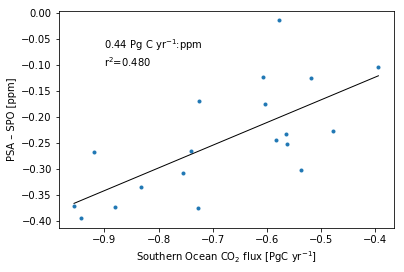

In [69]:
import statsmodels.api as sm
from scipy import stats
x, y = xr.align(soflux_djf, obs_djf.PSA_m_SPO, join='inner')

x = x.values
y = y.values
k = ~np.isnan(x) & ~np.isnan(y)
x = x[k]
y = y[k]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, '.')


model = sm.OLS(y, sm.add_constant(x))
fitted = model.fit()

print(fitted.params)
print(fitted.summary())

xhat = np.linspace(x.min(),x.max(),50)
yhat = fitted.predict(sm.add_constant(xhat))
ax.plot(xhat, yhat,'-',linewidth=1, color='k',zorder=10) 

ax.text(-0.9, -0.1,'{0:0.2f} Pg C yr$^{{-1}}$:ppm\nr$^2$={1:0.3f}'.format(fitted.params[1],fitted.rsquared))

ax.set_xlabel('Southern Ocean CO$_2$ flux [PgC yr$^{-1}$]')
ax.set_ylabel('PSA – SPO [ppm]')
#ax.set_title(n)

plt.savefig(f'{diro["fig"]}/psa-spo-v-flux-obs-djf.png', bbox_inches='tight', dpi=300)

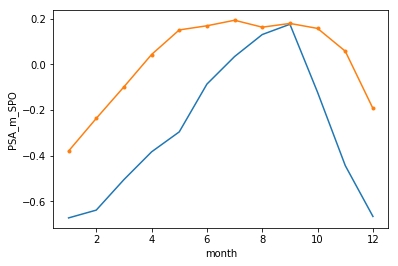

In [73]:
soflux_clim = soflux.groupby('time.month').mean('time')
obs_clim = obs.groupby('time.month').mean('time')

soflux_clim.plot()
obs_clim.PSA_m_SPO.plot(marker='.')

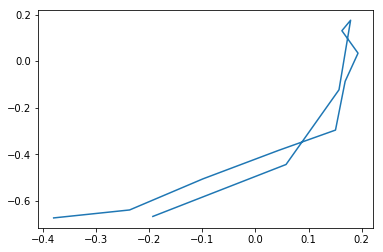

In [74]:
plt.plot(obs_clim.PSA_m_SPO, soflux_clim)